# Plot-drift-stats

Produces 4 figures for each isotopologue, displaying the isotopologue $\delta$ for each scan, the 6-minute running mean $\delta$, the Allan deviation and the Hadamard deviation. Also produces figures for $\Delta^{17}$O, $\Delta^{33}$S and $\Delta^{36}$S where appropriate.

### Inputs:
- Path to a folder which contains both 'data_sorted' and 'Allan_variance' subfolders. These are generated using the start of 'Orbitrap-data-sort-bracketing' followed by 'Allan-save' notebooks
- Ending of the specific file to be analysed
- Duration of running mean
- Save = true or false
- Save destination ('stats_plots')

### Outputs:
- Four subplots for each isotopologue, saved at the specified destination

### Allan and Hadamard deviations:
Allan deviation is the root-mean-square of the ratio difference between averaged blocks at each period:  
##### $\sigma_a^2 \approx \langle (\bar{y}_n-\bar{y}_{n+1})^2 \rangle  $
Hadamard deviation is the root-mean-square of the ratio second time derivative calculated from averaged blocks at each period. It is insensitive to linear drift:  
##### $\sigma_h^2 \approx \langle (\bar{y}_n-2\bar{y}_{n+1}+\bar{y}_{n+2})^2 \rangle  $
The Hadamard deviation is most relevant to the Orbitrap setup.

## Specify parameters

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# specify file
folder = ''
filesuffix = '_M0'

# averaging duration for plots (minutes)
meandur = 10

# save plots?
save=True
save_path = 'stats_plots'

## Load data

In [100]:
# specify file
files = [ file for file in os.listdir(os.path.join(folder,'data_sorted')) if file.split('_')[-2]=='sorted' and file.endswith(filesuffix+'.csv') ]
file=files[0]
path = os.path.join(folder,'data_sorted',file)

# finds corresponding allan deviaiton file
file_al = [ f for f in os.listdir(os.path.join(folder,'Allan_variance')) if f.startswith(file[0:10]) and f.endswith('_allan.csv') ][0]
path_al = os.path.join(folder,'Allan_variance',file_al)
file_ha = [ f for f in os.listdir(os.path.join(folder,'Allan_variance')) if f.startswith(file[0:10]) and f.endswith('_hadamard.csv')][0]
path_ha = os.path.join(folder,'Allan_variance',file_ha)
file_sp = [ f for f in os.listdir(os.path.join(folder,'Allan_variance')) if f.startswith(file[0:10]) and f.endswith('_spectrum.csv')][0]
path_sp = os.path.join(folder,'Allan_variance',file_sp)

print('Found data file at: \n'+path+'\nFound Allan Hadamard and Spectral files at:\n'+path_al+'\n'+path_ha+'\n'+path_sp)

# create folder for figures
if not os.path.exists(save_path):
    try:
        # Create the folder
        os.makedirs(save_path)
        print(f"Folder '{save_path}' created successfully")
    except OSError as e:
        print(f"Error creating folder: {e}")
else:
    print(f"Folder '{save_path}' already exists")


Found data file at: 
data_sorted/240312_001_sorted_M0.csv
Found Allan Hadamard and Spectral files at:
Allan_variance/240312_001_sorted_M0_allan.csv
Allan_variance/240312_001_sorted_M0_hadamard.csv
Allan_variance/240312_001_sorted_M0_spectrum.csv
Folder 'stats_plots' already exists


## Isotopologue $\delta$ plots

Folder 'stats_plots/NO3_M0' already exists


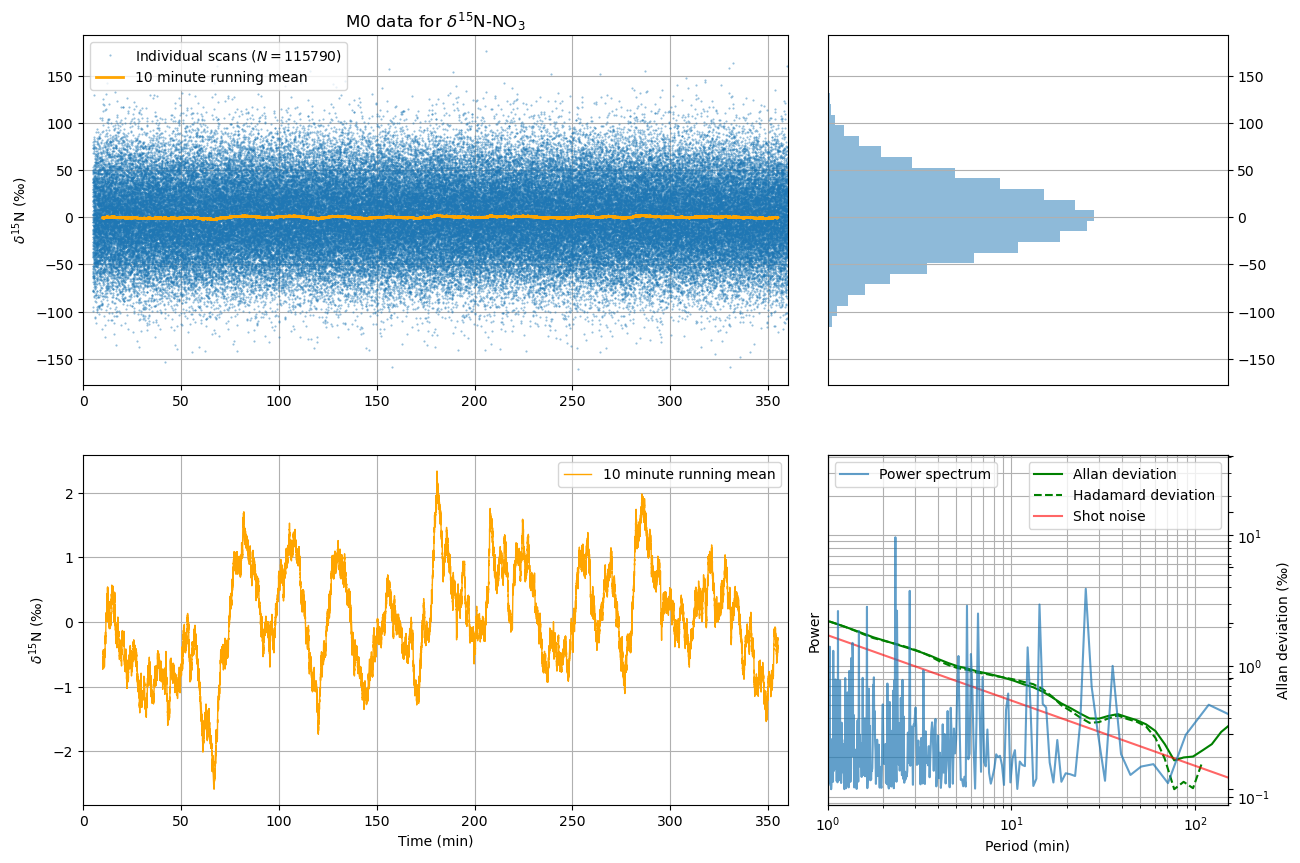

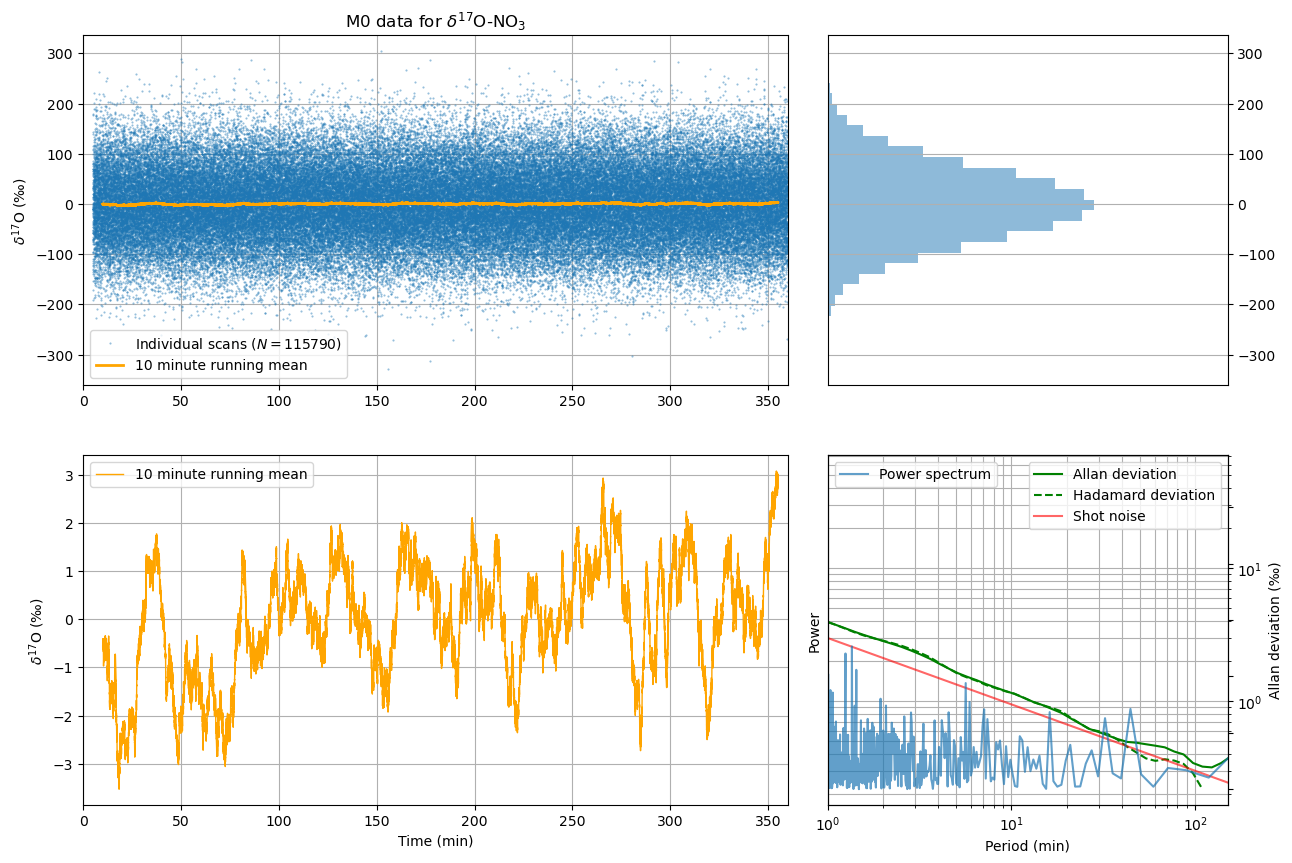

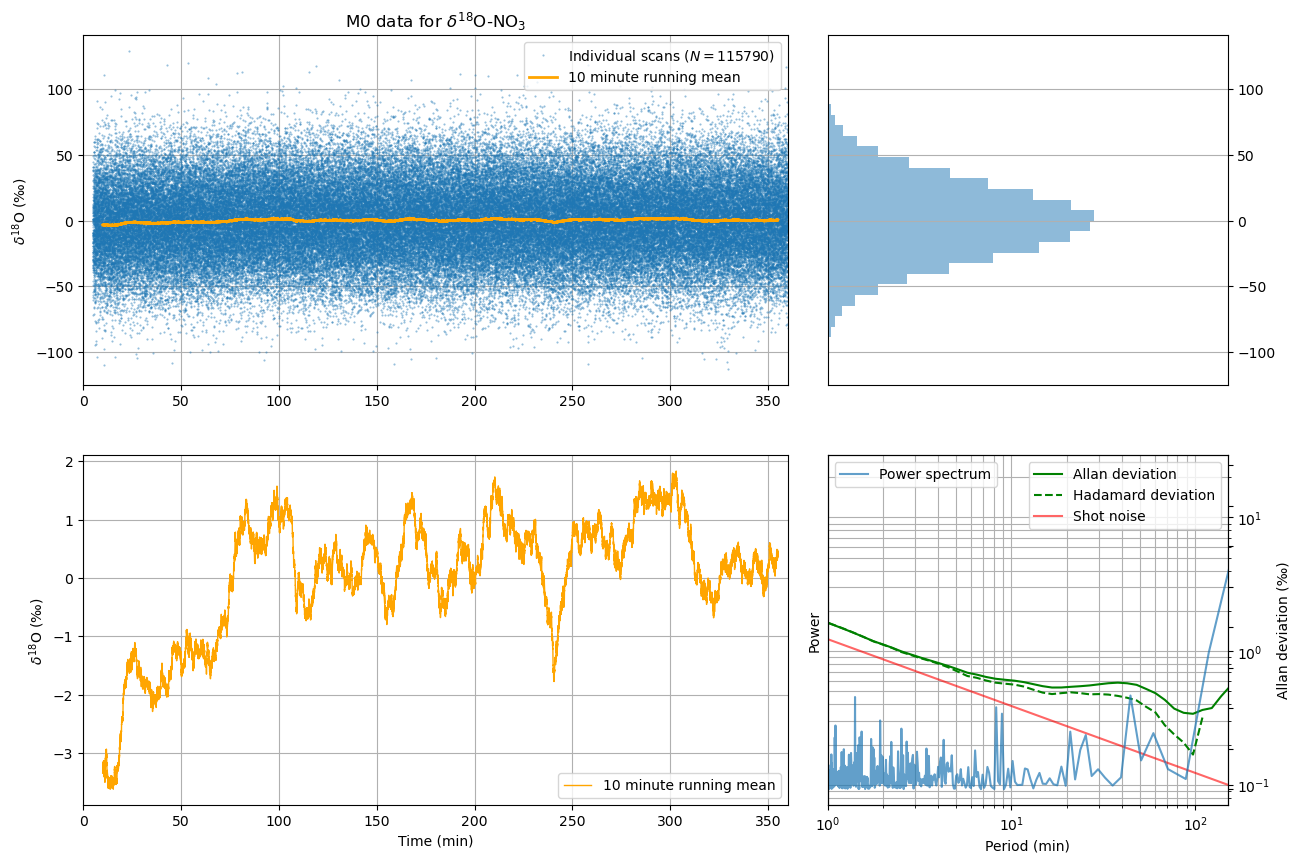

In [101]:
# fig2,axis2=plt.subplots()

data = pd.read_csv(path).dropna()
allan = pd.read_csv(path_al)
hadamard = pd.read_csv(path_ha)
spectrum = pd.read_csv(path_sp)

expt = data.loc[0,'experiment']

# create folder for figures
folder_path = os.path.join(save_path,expt)
if not os.path.exists(folder_path):
    try:
        # Create the folder
        os.makedirs(folder_path)
        print(f"Folder '{folder_path}' created successfully")
    except OSError as e:
        print(f"Error creating folder: {e}")
else:
    print(f"Folder '{folder_path}' already exists")
    
    
isotopologues = np.unique([col.split('_')[-1] for col in data.columns if col.startswith('Ratio_')])
if expt.endswith('_noM0'):
    isotopologues = [iso for iso in isotopologues if iso!='15N' and iso!='34S']

# formatted isotope names
iso_disp = []
for i, iso in enumerate(isotopologues):
    if len(iso) == 3:
        string = '$\delta^{' + iso[0:2] + "}$" + iso[2] 
        iso_disp.append(string)  
    elif len(iso)==6:
        string = '$\delta^{'+iso[0:2]+'}$'+iso[2]+'$^{'+iso[3:5]+'}$'+iso[5]
        iso_disp.append(string)
    else:
        iso_disp.append(iso)
        
        
for i,iso in enumerate(isotopologues):
    
    fig,axes = plt.subplots(2,2,figsize=[20,10])
    
    ax1 = axes[0,0]
    ax2 = axes[0,1]
    ax3 = axes[1,0]
    ax4 = axes[1,1]
    ax5 = ax4.twinx()
    pos1 = np.array(ax1.get_position())
    ax2.set_position([pos1[1][0]+0.02,pos1[0][1],0.2,pos1[1][1]-pos1[0][1]])
    pos3 = np.array(ax3.get_position())
    ax4.set_position([pos3[1][0]+0.02,pos3[0][1],0.2,pos3[1][1]-pos3[0][1]])
    
    ax1.set_title(expt.split('_')[1]  + ' data for '+iso_disp[i] + '-' + expt[0:2]+'$_'+expt[2]+'$')
    
    # data
    time = data['time.min']
    ratios = data['Ratio_'+iso]
    deltas = ratios/ratios.mean()-1
    
    # running mean 
    scandur = (time.iloc[-1]-time.iloc[0])/len(time)
    window_size = int(meandur / scandur)
    rolling_mean_delta = deltas.rolling(window=window_size, center=True).mean()
    rolling_std = rolling_mean_delta.std()
    
    # allan, hadamard deviation, spectrum
    atau = allan['atau_'+iso]
    adev = allan['adev_'+iso]
    htau = hadamard['htau_'+iso]
    hdev = hadamard['hdev_'+iso]
    n_eff = allan['mean_n_eff_'+iso].iloc[0]
    freq = spectrum['freq_'+iso]
    power = spectrum['power_'+iso]
    
    ax1.plot(time,deltas*1000,lw=0,marker='o',ms=0.5,alpha=0.5,label='Individual scans ($N='+str(len(data))+'$)')
    ax1.plot(time,rolling_mean_delta*1000,lw=2,label=str(meandur)+' minute running mean',c='orange')
    ax1.set_ylabel(iso_disp[i] +' (‰)')
    # ax1.set_ylim([-250,250])
    ax1.set_xlim([0,360])
    ax1.grid(True,axis='both')
   
    ax1.legend()

    hist = ax2.hist(deltas*1000,bins=30,alpha=0.5,orientation='horizontal')
    ax2.set_ylim(ax1.get_ylim())
    ax2.set_xlim([0,np.max(hist[0])*1.5])
    ax2.set_xticks([])
    ax2.grid()
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")

    ax3.plot(time,rolling_mean_delta*1000,lw=1,label=str(meandur)+' minute running mean',color='orange')
    # ax3.set_ylim([-6,6])
    ax3.set_xlim(ax1.get_xlim())
    ax3.grid(True,axis='both')
    ax3.set_ylabel(ax1.get_ylabel())
    ax3.set_xlabel('Time (min)')
    ax3.legend()
    

#     axis2.plot(time,rolling_mean_delta*1000,lw=1,label=iso,alpha=0.6)
#     # ax3.set_ylim([-6,6])
#     axis2.set_xlim(ax1.get_xlim())
#     axis2.grid(True,axis='both')
#     axis2.set_ylabel(ax1.get_ylabel())
#     axis2.set_xlabel('Time (min)')
#     axis2.legend()

    
    ax4.loglog(atau/60,adev,c='green',label='Allan deviation')
    ax4.loglog(htau/60,hdev,c='green',ls='--',label='Hadamard deviation')
    ax4.loglog(atau/60,1000*(atau*n_eff/(60*scandur))**-0.5, c='r',label='Shot noise',alpha=0.6)
    ax4.set_xlim([1,150])
    ax4.legend()
    ax4.set_ylabel('Allan deviation (‰)')
    ax4.set_xlabel('Period (min)')
    ax4.grid(which='both')
    # ax4.set_title('Allan deviation')
    ax4.yaxis.tick_right()
    ax4.yaxis.set_label_position("right")
    
    ax5.plot(1/freq, power, label='Power spectrum',alpha=0.7) 
    ax5.set_ylabel('Power')
    ax5.set_yticklabels([])
    ax5.legend(loc='upper left')
    ax5.yaxis.set_label_position("left")

    if save:
       
        fig.savefig(os.path.join(folder_path,iso+'_'+expt))
        

## MIF $\Delta$ plots

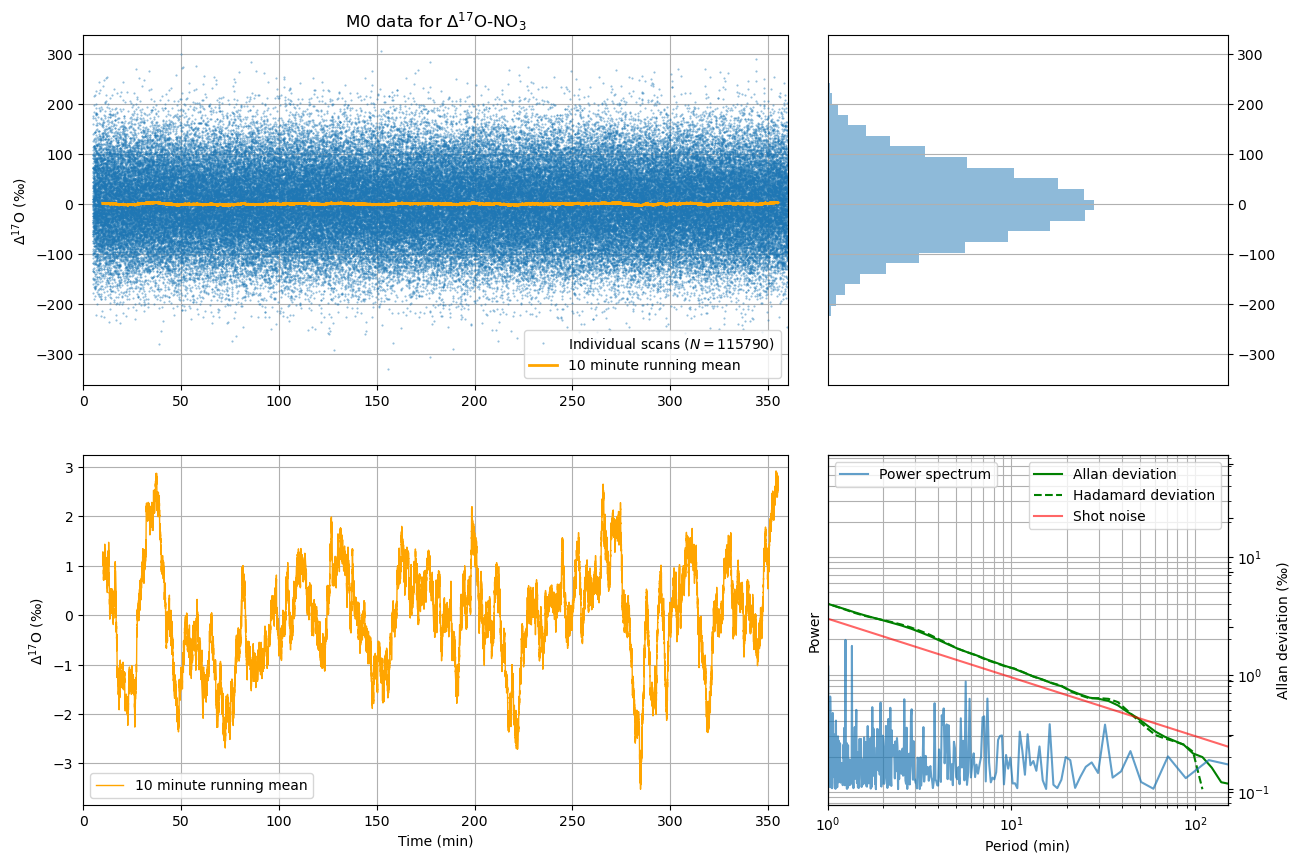

In [102]:
data = pd.read_csv(path).dropna()
allan = pd.read_csv(path_al)
hadamard = pd.read_csv(path_ha)
spectrum = pd.read_csv(path_sp)

if expt=='SO4_M0':
    isotopologues = ['D17O','D33S']
    comps = {'D17O':['17O','18O',0.52],
             'D33S':['33S','34S',0.51]}
elif expt=='SO4_noM0':
    isotopologues = ['D17O','D33S','D36S']
    comps = {'D17O':['17O','18O',0.52],
             'D33S':['33S','34S',0.51],
             'D36S':['36S','34S',1.96]}
elif expt.startswith('NO3'):
    isotopologues = ['D17O']
    comps = {'D17O':['17O','18O',0.52]}

# formatted isotope names
iso_disp = []
for i, iso in enumerate(isotopologues):
    if len(iso) == 4:
        string = '$\Delta^{' + iso[1:3] + "}$" + iso[3] 
        iso_disp.append(string)  
    elif len(iso)==7:
        string = '$\Delta^{'+iso[1:3]+'}$'+iso[3]+'$^{'+iso[4:6]+'}$'+iso[6]
        iso_disp.append(string)
    else:
        iso_disp.append(iso)
        
        
for i,iso in enumerate(isotopologues):
    
    fig,axes = plt.subplots(2,2,figsize=[20,10])
    
    ax1 = axes[0,0]
    ax2 = axes[0,1]
    ax3 = axes[1,0]
    ax4 = axes[1,1]
    ax5 = ax4.twinx()
    pos1 = np.array(ax1.get_position())
    ax2.set_position([pos1[1][0]+0.02,pos1[0][1],0.2,pos1[1][1]-pos1[0][1]])
    pos3 = np.array(ax3.get_position())
    ax4.set_position([pos3[1][0]+0.02,pos3[0][1],0.2,pos3[1][1]-pos3[0][1]])
  
    ax1.set_title(expt.split('_')[1]  + ' data for '+iso_disp[i] + '-' + expt[0:2]+'$_'+expt[2]+'$')
  
    # data
    time = data['time.min']
    
    deltas=((data['Ratio_'+comps[iso][0]]/data['Ratio_'+comps[iso][0]].mean()-1) -
                                               comps[iso][2]*(data['Ratio_'+comps[iso][1]]/data['Ratio_'+comps[iso][1]].mean()-1))

    
    # running mean 
    scandur = (time.iloc[-1]-time.iloc[0])/len(time)
    window_size = int(meandur / scandur)
    rolling_mean_delta = deltas.rolling(window=window_size, center=True).mean()
    rolling_std = rolling_mean_delta.std()
    
    # allan, hadamard deviation, spectrum
    atau = allan['atau_'+iso]
    adev = allan['adev_'+iso]
    htau = hadamard['htau_'+iso]
    hdev = hadamard['hdev_'+iso]
    n_eff = allan['mean_n_eff_'+iso].iloc[0]
    freq = spectrum['freq_'+iso]
    power = spectrum['power_'+iso]
    
    ax1.plot(time,deltas*1000,lw=0,marker='o',ms=0.5,alpha=0.5,label='Individual scans ($N='+str(len(data))+'$)')
    ax1.plot(time,rolling_mean_delta*1000,lw=2,label=str(meandur)+' minute running mean',c='orange')
    ax1.set_ylabel(iso_disp[i] +' (‰)')
    # ax1.set_ylim([-250,250])
    ax1.set_xlim([0,360])
    ax1.grid(True,axis='both')
    ax1.legend()

    hist = ax2.hist(deltas*1000,bins=30,alpha=0.5,orientation='horizontal')
    ax2.set_ylim(ax1.get_ylim())
    ax2.set_xlim([0,np.max(hist[0])*1.5])
    ax2.set_xticks([])
    ax2.grid()
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")

    ax3.plot(time,rolling_mean_delta*1000,lw=1,label=str(meandur)+' minute running mean',color='orange')
    ax3.set_xlim(ax1.get_xlim())
    ax3.grid(True,axis='both')
    ax3.set_ylabel(ax1.get_ylabel())
    ax3.set_xlabel('Time (min)')
    ax3.legend()
    
    ax4.loglog(atau/60,adev,c='green',label='Allan deviation')
    ax4.loglog(htau/60,hdev,c='green',ls='--',label='Hadamard deviation')
    ax4.loglog(atau/60,1000*(atau*n_eff/(60*scandur))**-0.5, c='r',label='Shot noise',alpha=0.6)
    ax4.set_xlim([1,150])
    ax4.legend()
    ax4.set_ylabel('Allan deviation (‰)')
    ax4.set_xlabel('Period (min)')
    ax4.grid(which='both')
    # ax4.set_title('Allan deviation ')
    ax4.yaxis.tick_right()
    ax4.yaxis.set_label_position("right")
    

    ax5.plot(1/freq, power, label='Power spectrum', alpha=0.7)  
    ax5.set_ylabel('Power')
    ax5.set_yticklabels([])
    ax5.legend(loc='upper left')
    ax5.yaxis.set_label_position("left")

    
    
    if save:
        fig.savefig(os.path.join(folder,'Drift+Allan_plot_'+iso+'_'+folder))
        fig.savefig('Drift+Allan_plot_'+iso+'_'+folder)
        
    
    